In [4]:
# !pip install torch lightning pytorch-lightning
# !pip install wandb -qU

In [5]:
import torch
import pytorch_lightning as p
from pytorch_lightning.loggers import WandbLogger
import wandb

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_16352\316793476.py", line 2, in <module>
    import pytorch_lightning as p
  File "C:\Users\ASUS\anaconda3\envs\pytorch_env\Lib\site-packages\pytorch_lightning\__init__.py", line 25, in <module>
    from lightning_fabric.utilities.seed import seed_everything  # noqa: E402
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\envs\pytorch_env\Lib\site-packages\lightning_fabric\__init__.py", line 29, in <module>
    from lightning_fabric.fabric import Fabric  # noqa: E402
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\envs\pytorch_env\Lib\site-packages\lightning_fabric\fabric.py", line 22, in <module>
    import torch.nn as nn
  File "C:\Users\ASUS\anac

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ASUS/.netrc


True

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data=datasets.MNIST(root='data',
                          train=True,
                          transform=ToTensor(),
                          download=True)

test_data=datasets.MNIST(root='data',
                        train=False,
                        transform=ToTensor())

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
len(train_data)

60000

In [10]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


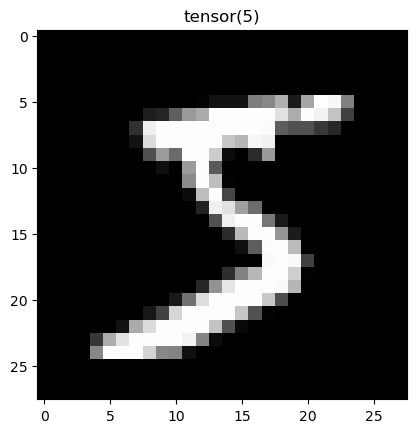

In [11]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0],cmap='gray')
plt.title(train_data.targets[0])
plt.show()

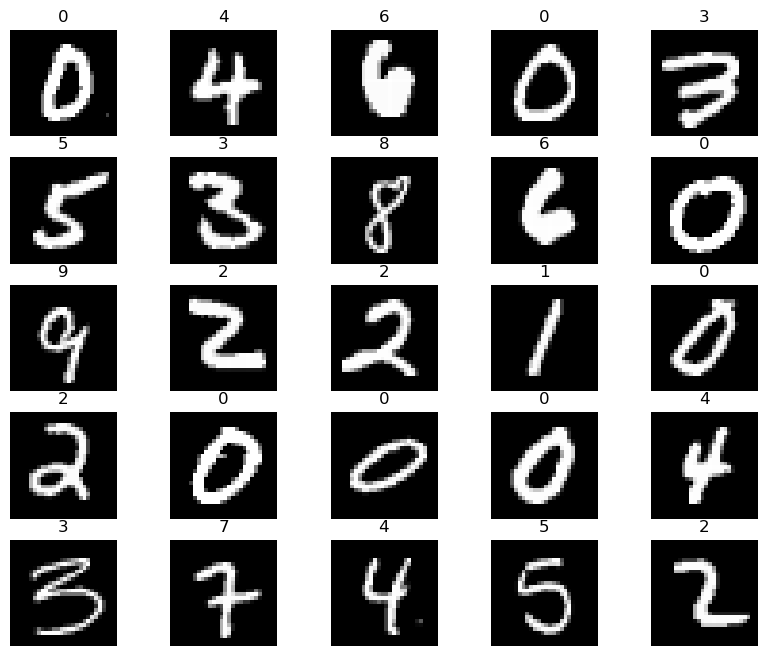

In [12]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split


train_indices, val_indices,_,_ = train_test_split(
    range(len(train_data)),
    train_data.targets,
    stratify=train_data.targets,
    test_size=0.2)

In [14]:
train_split=torch.utils.data.Subset(train_data,train_indices)
val_split=torch.utils.data.Subset(train_data,val_indices)

In [16]:
# datamodule.test_dataloader()

In [17]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import torch

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.batch_size = 32
        self.train_split=None
        self.val_split=None
        self.test_split=None

    def prepare_data(self):
        datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
        datasets.MNIST(root='data', train=False, transform=ToTensor(), download=True)

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=False)
            self.test_dataset = datasets.MNIST(root='data', train=False, transform=ToTensor(), download=False)

            self.train_indices, self.val_indices, _, _ = train_test_split(
                range(len(self.train_dataset)),
                self.train_dataset.targets,
                stratify=self.train_dataset.targets,
                test_size=0.2
            )

            self.train_split = torch.utils.data.Subset(self.train_dataset, self.train_indices)
            self.val_split = torch.utils.data.Subset(self.train_dataset, self.val_indices)
            

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_split, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_split, batch_size=self.batch_size)

    def test_dataloader(self:p.LightningDataModule):
        self.test_indices = range(len(self.test_dataset))
        self.test_split = torch.utils.data.Subset(self.test_dataset, self.test_indices)
        return torch.utils.data.DataLoader(self.test_split, batch_size=self.batch_size)
       

In [18]:
class ImagePredictionLogger(pl.callbacks.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })
        

In [19]:
import torch.nn as nn
import torchmetrics

class CNN(p.LightningModule):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1= nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,              
                stride=1,                   
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
            
        self.fc1=nn.Linear(32*7*7,10)
        
        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.test_acc  = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        
        self.save_hyperparameters()
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        
        x = x.view(x.size(0), -1)   
        
        out=self.fc1(x)
        
        return out
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=0.001)
    
    def training_step(self, batch, batch_idx):
        x,y=batch
        y_pred=self(x)
        loss=nn.CrossEntropyLoss()(y_pred,y)
        self.train_acc(y_pred, y)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=False, logger=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y=batch
        y_pred = self(x)
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.valid_acc(y_pred, y)
        self.log('val_acc', self.valid_acc, on_step=True, on_epoch=True)
        self.log("val_loss", loss)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log("test_loss", loss)
        self.test_acc(y_pred, y)
        self.log('test_acc', self.test_acc)
        return loss

In [20]:
CNN()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (valid_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
)

In [21]:
class LoggingCallback(p.Callback):
    def on_train_epoch_end(self,trainer:p.Trainer,pl_module: p.LightningModule):
        epoch = trainer.current_epoch
        logs=trainer.callback_metrics

        loss = logs.get('train_loss')
        accuracy = logs.get('train_acc')

        
        print(f"Epoch {epoch} - Training Loss: {loss} - Accuracy: {accuracy}")
    
    def on_validation_epoch_end(self, trainer: p.Trainer, pl_module: p.LightningModule) -> None:
      
        epoch = trainer.current_epoch
        logs=trainer.callback_metrics

        accuracy=logs.get('val_acc')
        loss = logs.get('val_loss')

        print(f"Epoch {epoch} - V Loss: {loss} - Accuracy: {accuracy}")
        
    

In [22]:
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping

checkpoint_callback = ModelCheckpoint(
        monitor='val_acc', 
        save_top_k=1, 
        mode='max',
        dirpath='saved/',
        filename='sample-mnist-{epoch:02d}-{val_loss:.2f}')
    
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)


In [35]:
test_dataloader= datamodule.test_dataloader()



for batch in test_dataloader:
    x,y=batch
    val_imgs, val_labels=x,y
    print(y)
#     val_imgs, val_labels = val_samples[0], val_samples[1]
    break

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])


In [37]:


# Initialize wandb logger
wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')



# Initialize a trainer
trainer = pl.Trainer(max_epochs=2,
                     logger=wandb_logger,
                     callbacks=[early_stopping_callback,
#                                 ImagePredictionLogger(val_samples),
                                LoggingCallback(),
                                checkpoint_callback],
                     )

# Train the model ⚡🚅⚡
trainer.fit(model, datamodulemo)



# Close wandb run
wandb.finish()

Problem at: C:\Users\ASUS\anaconda3\Lib\site-packages\wandb\sdk\wandb_init.py 829 getcaller
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_4620\3564789179.py", line 2, in <module>
    wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\loggers\wandb.py", line 359, in __init__
    _ = self.experiment
        ^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\lightning_fabric\loggers\logger.py", line 118, in experiment
    return fn(self)
           ^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\loggers\wandb.py", line 407, in experiment
    self._experiment = wandb.init(**self._wandb_init)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Us

In [40]:
datamodule = MNISTDataModule()
model = CNN()
trainer = p.Trainer(
        callbacks=[LoggingCallback(),checkpoint_callback,early_stopping_callback],
        max_epochs=10
    )
trainer.fit(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\ASUS\Desktop\saved exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | conv1     | Sequential         | 416   
1 | conv2     | Sequential         | 12.8 K
2 | fc1       | Linear             | 15.7 K
3 | train_acc | MulticlassAccuracy | 0     
4 | valid_acc | MulticlassAccuracy | 0     
5 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0 - V Loss: 2.3020777702331543 - Accuracy: 0.109375


C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0 - V Loss: 0.07186383754014969 - Accuracy: 0.9799166917800903
Epoch 0 - Training Loss: 0.16809380054473877 - Accuracy: 0.9375


In [109]:
trainer.test(model=model,datamodule=datamodule)

C:\Users\ASUS\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9896000027656555
        test_loss           0.04656601697206497
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.04656601697206497, 'test_acc': 0.9896000027656555}]

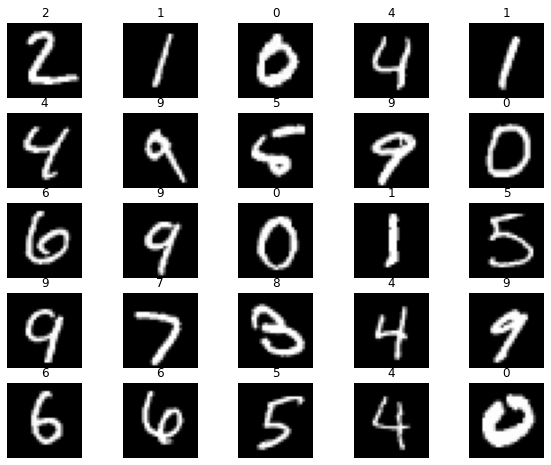

In [133]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img=x[i]
    figure.add_subplot(rows, cols, i)
    plt.title(pred[i])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [38]:
import wandb

import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

In [39]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, lr=1e-3, inp_size=28, optimizer = 'Adam'):
        super().__init__()

        self.encoder = nn.Sequential(nn.Linear(inp_size * inp_size, 64), nn.ReLU(), nn.Linear(64, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, inp_size * inp_size))
        self.lr = lr

        # save hyper-parameters to self.hparamsm auto-logged by wandb
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        
        # log metrics to wandb
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(lr=1e-3, inp_size=28)

# setup data
batch_size = 32
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset, shuffle=True)

# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='my-awesome-project')

# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = batch_size

# pass wandb_logger to the Trainer 
trainer = pl.Trainer(limit_train_batches=750, max_epochs=5, logger=wandb_logger)

# train the model
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()


100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:25<00:00, 388259.25it/s]


Extracting C:\Users\ASUS\Desktop\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\ASUS\Desktop\MNIST\raw




100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 741140.41it/s]


Extracting C:\Users\ASUS\Desktop\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\ASUS\Desktop\MNIST\raw




100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:04<00:00, 333313.75it/s]


Extracting C:\Users\ASUS\Desktop\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\ASUS\Desktop\MNIST\raw




100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4547750.96it/s]

Extracting C:\Users\ASUS\Desktop\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\ASUS\Desktop\MNIST\raw



Problem at: C:\Users\ASUS\anaconda3\Lib\site-packages\wandb\sdk\wandb_init.py 829 getcaller
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_4620\1908653387.py", line 37, in <module>
    wandb_logger = WandbLogger(project='my-awesome-project')
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\loggers\wandb.py", line 359, in __init__
    _ = self.experiment
        ^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\lightning_fabric\loggers\logger.py", line 118, in experiment
    return fn(self)
           ^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\loggers\wandb.py", line 407, in experiment
    self._experiment = wandb.init(**self._wandb_init)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-p